# Raster data handling with rasterio

In this Notebook we open and explore two spectral bands from the Sentinel-2 satellite, calculate the NDVI and save the NDVI raster to a GeoTiff. Along this way, we touch a couple of issues related to raster handling using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package.

## Read Sentinel-2 bands

Define the bands to open with rasterio. Rasterio's ``open()`` function returns an opened dataset object.

In [2]:
import rasterio
from pathlib import Path
data_dir = Path('F:/OneDrive - uibk.ac.at/FE_WS2324/data')      # Set your local path to the data
b04 = rasterio.open(data_dir / 'S2' / 'T32TPT_20201122T102339_B04_10m.jp2')     # This is the red band
b08 = rasterio.open(data_dir / 'S2' / 'T32TPT_20201122T102339_B08_10m.jp2')     # This is the NIR band

Once we have established a file connection with (`rasterio.open()`), we can access two types of data from the of the opened dataset object:

* the `numpy` array containing the raster values (in a single band raster one value per pixel (raster cell))
* and the metadata.

Have a look at georeferencing attributes stored with the Band 4 raster, namely
* Affine transformation matrix that maps pixel locations from image space ((col, row) coordinates) to (x, y) spatial positions (you can see the spatial resolution/pixel size and the upper left corner coordinates)
* Coordinate reference system (CRS) where spatial positions relate to
* Shape and bounding box

In [3]:
print(b04.transform)    # Affine transformation matrix
print(b04.crs)          # Coordinate reference system EPSG code
print(b04.shape)        # Print also the shape of a04 (number of pixels in both dimensions)
print(b04.bounds)       # Bounding box

| 10.00, 0.00, 600000.00|
| 0.00,-10.00, 5300040.00|
| 0.00, 0.00, 1.00|
EPSG:32632
(10980, 10980)
BoundingBox(left=600000.0, bottom=5190240.0, right=709800.0, top=5300040.0)


... or simply print all the metadata.

In [4]:
print(b04.meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5300040.0)}


Read the bands, which returns a ``numpy.ndarray``. We want the pixel values as float, so that in the next step the NDVI will be float as well. Why do the bands contain integers, reflectance should be between 0 and 1?

In [5]:
a04=b04.read(1).astype(float)
a08=b08.read(1).astype(float)

For the bands opened as numpy arrays, we can easily calculate basic statistics.

In [6]:
print(a04.min())
print(a04.max())
print(a04.mean())

0.0
16080.0
1473.3225049269909


## Plotting

Plot one band using rasterio's built-in ``show()`` method.

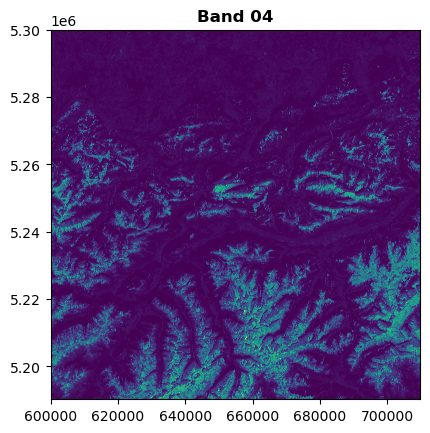

<Axes: title={'center': 'Band 04'}>

In [7]:
from rasterio.plot import show
show(b04, title='Band 04')

Show also the histogram for this band.

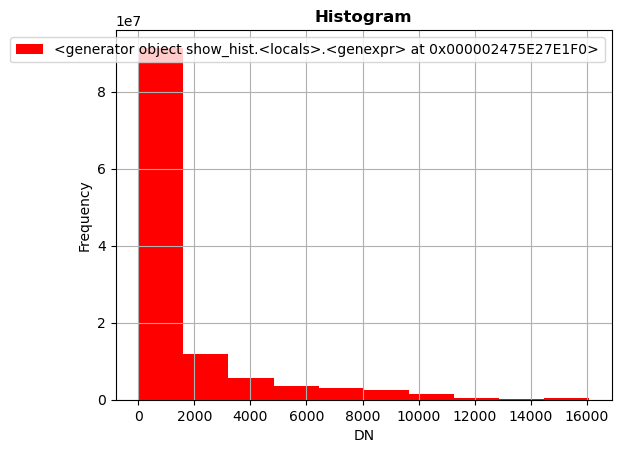

In [8]:
from rasterio.plot import show_hist
show_hist(b04)

## Calculate the NDVI

Now we calculate the [normalized difference vegetation index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) from the float bands.

In [9]:
ndvi = (a08-a04)/(a08+a04)

C:\Users\Andi\AppData\Local\Temp\ipykernel_14140\2912796907.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi = (a08-a04)/(a08+a04)


## Write the NDVI to a GeoTiff

In [10]:
with rasterio.open(
    data_dir / 'S2' / 'ndvi.tif',       # output file
    mode="w",                           # write mode
    driver="GTiff",                     
    height=b04.shape[0],                # number of rows of the raster
    width=b04.shape[1],                 # number of columns of the raster
    count=1,                            # a count of the raster bands (NDVI is only one band)
    dtype=a04.dtype,                    # data type (same as for a04)
    crs=b04.crs,                        # write the same CRS as the source bands have
    transform=b04.transform             # write the same transform as the source bands have
) as new_dataset:
    new_dataset.write(ndvi, 1)           # write NDVI data to band at location 1

## Close datasets

We should close opened datasets.

In [12]:
b04.close()
b08.close()

As Python `file` objects can, Rasterio datasets can manage the entry into and exit from runtime contexts created using a `with` statement. This ensures that files are closed no matter what exceptions may be raised within the the block. We do this in the next cell ...

## Plotting raster data

Try plotting the NDVI raster with matplotlib ...

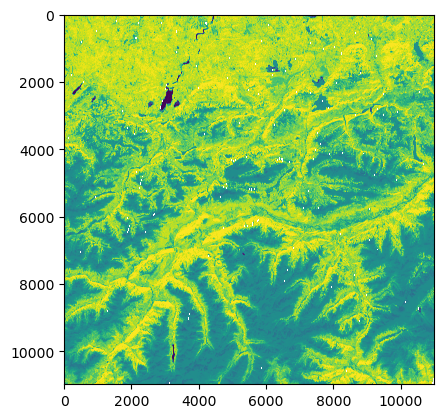

In [14]:
import matplotlib.pyplot as plt
with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:
    plt.imshow(src.read(1))

... and with rasterio's built-in plotting methods. What's the difference?

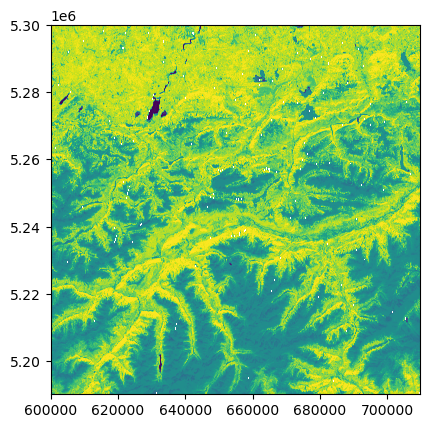

In [16]:
from rasterio.plot import show
with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:
    show(src.read(), transform=src.transform)       # Use the transform attribute to get CRS coordinates.

... and a histogram.

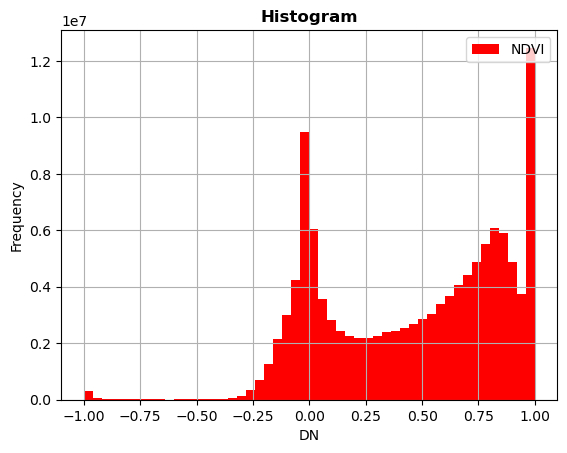

In [17]:
from rasterio.plot import show_hist
with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:
    show_hist(src, bins=50, label='NDVI')